# Looking at videos with no detected faces

In [7]:
#export
from fastai.vision import *
from IPython.display import HTML
import cv2
import pandas as pd
from facenet_pytorch import MTCNN

from kgl_deepfake.nb_00 import *

### Data

In [2]:
SOURCE = Path('../data/train_sample_videos/')

In [3]:
annots = pd.read_csv('annots_noface.csv')

In [4]:
annots.head()

,fname,label,split,original
0,adhsbajydo.mp4,FAKE,train,fysyrqfguw.mp4
1,agrmhtjdlk.mp4,REAL,train,NaN
2,andaxzscny.mp4,FAKE,train,fysyrqfguw.mp4
3,aorjvbyxhw.mp4,FAKE,train,bulkxhhknf.mp4
4,atvmxvwyns.mp4,REAL,train,NaN


In [5]:
fnames = [SOURCE/o for o in annots.fname]
labels = [f'{o.fname} {o.label}' for i, o in annots.iterrows()]

In [8]:
HTML(html_vids(fnames, titles=labels))

### Darkish videos

Many of these videos have poor lighting.  Let's consider these in this section.

In [201]:
fn = 'atvmxvwyns.mp4'

In [202]:
vcap = cv2.VideoCapture(str(SOURCE/fn))

In [203]:
success, frame = vcap.read()

In [204]:
success

True

In [205]:
vcap.release()

In [206]:
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#frame = PIL.Image.fromarray(frame)

In [207]:
pilimg = PIL.Image.fromarray(frame)
img = tensor(frame).permute(2, 0, 1)

Scale up all values increases the brightness of the image.  (Don't know if there is a better way to increase brightness.)

In [208]:
img_brighter = (2 * img.float()).clamp_max(255).clamp_min(0).type(torch.uint8)

In [209]:
pilimg_brighter = PIL.Image.fromarray(img_brighter.permute(1, 2, 0).numpy())

tensor([44.7277, 32.8818, 23.9042])

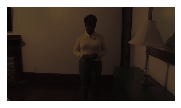

In [210]:
Image(img).show(); img.float().mean(dim=[1, 2])

tensor([89.4554, 65.7637, 47.8085])

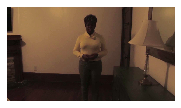

In [211]:
Image(img_brighter).show(); img_brighter.float().mean(dim=[1, 2])

In [212]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [213]:
detector = MTCNN(device=device, post_process=False)

In [214]:
face = detector(pilimg)

In [215]:
face is None

True

In [216]:
face_brighter = detector(pilimg_brighter)

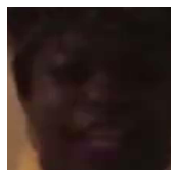

In [219]:
Image(face_brighter.type(torch.uint8)).show()

By increasing the brightness, a face from the first frame of the following videos is detected:

* esyhwdfnxs.mp4 2x  
* eoewqcpbgt.mp4 2x
* atvmxvwyns.mp4 2x

'2x' indicates that the image array was multiplied by 2.  Multiplying by 1.5 didn't work, at least not for the first video listed here.

# - fin